In [1]:
import os
import time
import warnings
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from deepMNN import correct_scanpy
from metrics import compute_entropy, silhouette_coeff_ASW

import anndata as ad
import scanpy as sc
from src.models import scETM
from src.trainers import UnsupervisedTrainer,prepare_for_transfer
from src import  evaluate
sc.set_figure_params(dpi=120, dpi_save=250, fontsize=10, figsize=(10, 10), facecolor="white")

warnings.filterwarnings("ignore")

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100)
sc.settings.set_figure_params(dpi_save=300)
sc.logging.print_version_and_date()

os.environ["CUDA_VISIBLE_DEVICES"]="1"

Running Scanpy 1.8.2, on 2021-12-21 23:20.


In [2]:
mp_csvs = ['GSM2230761_mouse1_umifm_counts.csv', 'GSM2230762_mouse2_umifm_counts.csv']
mp_adatas = []
for fpath in mp_csvs:
    df = pd.read_csv(fpath, index_col=0)
    adata = ad.AnnData(X=df.iloc[:, 2:], obs=df.iloc[:, :2])
    mp_adatas.append(adata)
adata= ad.concat(mp_adatas, label="batch_indices")

In [3]:
#adata = sc.read_h5ad('data/dataset5.h5ad')

#adata = adata[(adata.obs.batch != '0') | (adata.obs.celltype != 'B cell')]
#adata = adata[(adata.obs.batch != '1') | (adata.obs.celltype != 'NK cell')]
#adata = adata[(adata.obs.batch != '1') | (adata.obs.celltype != 'Monocyte_CD14')]
#adata = adata[(adata.obs.batch != '0') | (adata.obs.celltype != 'CD8 T cell')]


sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:,adata.var.highly_variable]
# sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


In [21]:
batch_names = adata.obs['batch_indices'].value_counts().index.values
adatas = [adata[adata.obs['batch_indices'] == batch_names[i]] for i in range(0, len(batch_names))]

['1', '0']
Categories (2, object): ['0', '1']

# Before batch correction

In [5]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
asw_raw = silhouette_coeff_ASW(adata,batch_key='batch_indices',celltype_key='assigned_cluster')
entropy_raw=compute_entropy(adata,batch_key='batch_indices',celltype_key='assigned_cluster')

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
Calculating entropy ...
use exist neighbors
Entropy calculated!


... storing 'barcode' as categorical
... storing 'assigned_cluster' as categorical


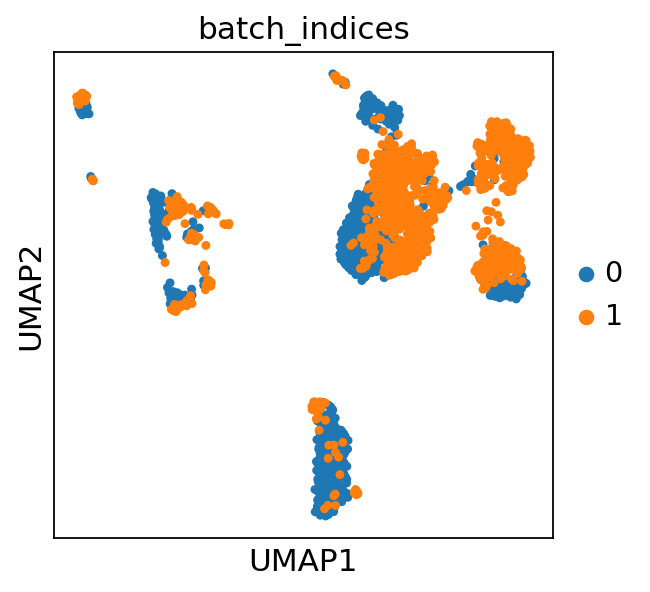

In [6]:
sc.pl.umap(adata,color='batch_indices',save='_figure_mouse.pdf')

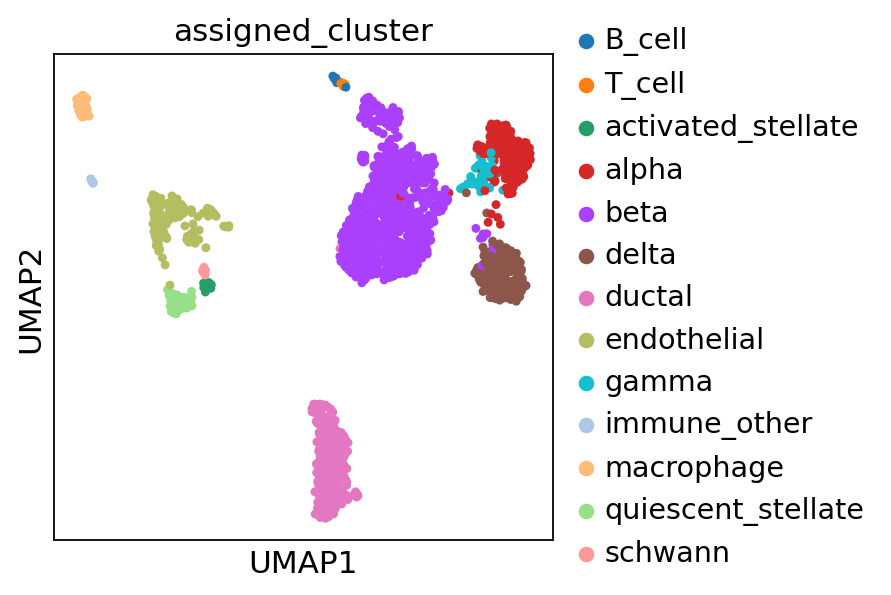

In [7]:
sc.pl.umap(adata,color='assigned_cluster',save='_figure_mouse.pdf')

# Batch correction using deepMNN

tensor(0.2956, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2893, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2850, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2807, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2759, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2706, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2647, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2581, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2512, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2439, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2364, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2289, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2216, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2145, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2076, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.2011, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.1951, device='cuda:1', grad_fn=

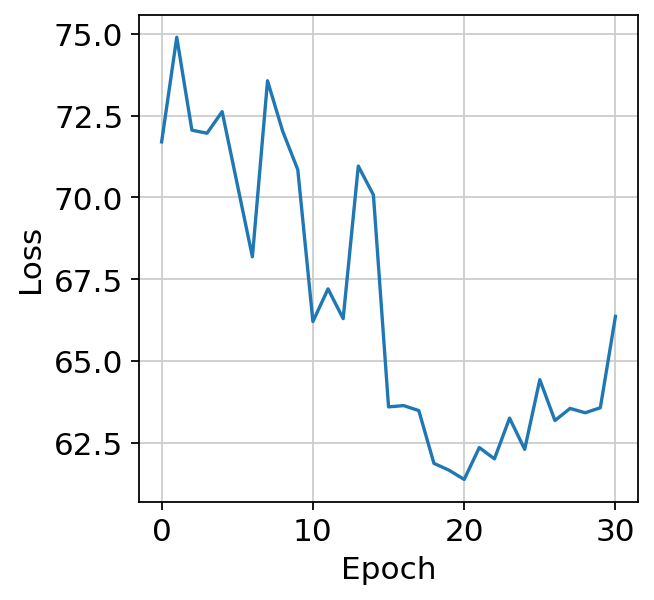

In [8]:
time_s = time.time()
corrected = correct_scanpy(adatas,plot_loss= True)
print('time used:', time.time()-time_s)

adata_result = corrected[0].concatenate(corrected[1:], join='inner', batch_key = 'batch_indices')
sc.tl.pca(adata_result, svd_solver='arpack')
sc.pp.neighbors(adata_result)
sc.tl.umap(adata_result)

asw_deepMNN = silhouette_coeff_ASW(adata_result,batch_key='batch_indices',celltype_key='assigned_cluster')
entropy_deepMNN=compute_entropy(adata_result,celltype_key='assigned_cluster',batch_key='batch_indices')


... storing 'barcode' as categorical
... storing 'assigned_cluster' as categorical


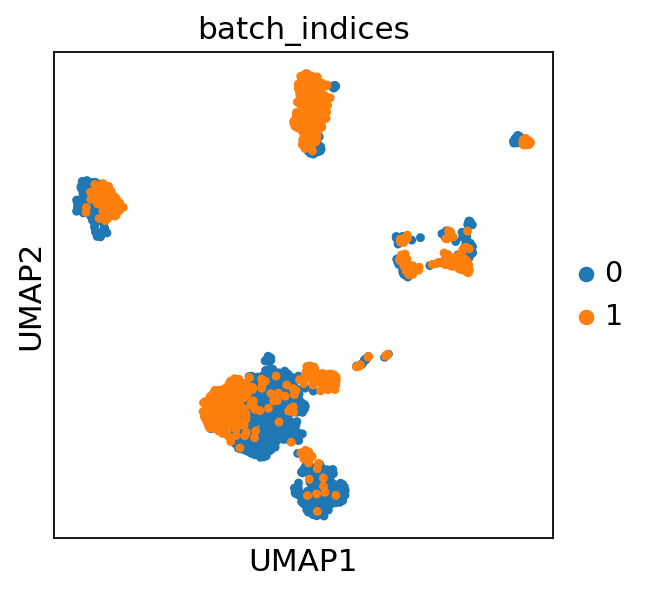

In [9]:
#adata_result.obs['batch'] = ['10X 3\'' if i == '0' else '10X 5\'' for i in adata_result.obs['batch']]
sc.pl.umap(adata_result,color='batch_indices',save='_figure_mouse_deepMNN_batch.pdf')

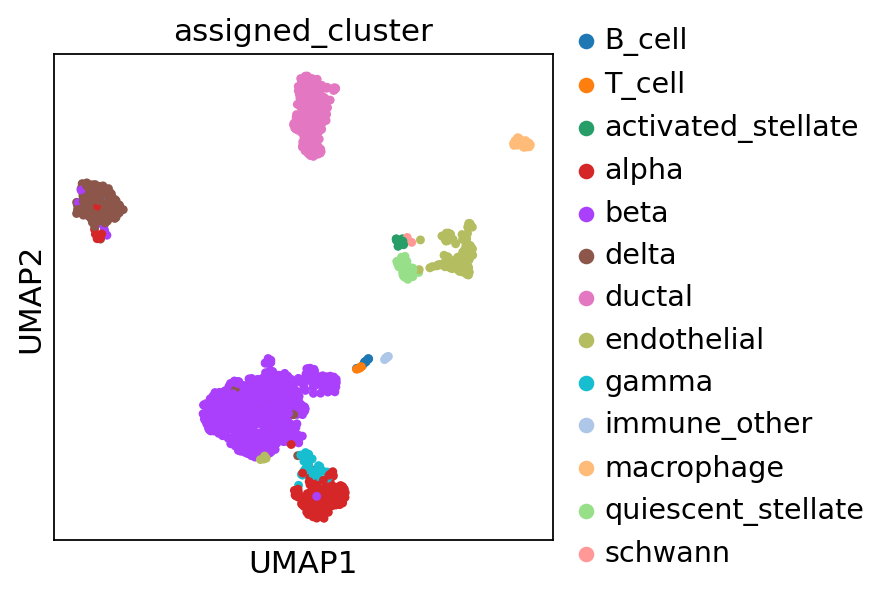

In [10]:
sc.pl.umap(adata_result,color='assigned_cluster',save='_figure_mouse_deepMNN_celltype.pdf')

In [11]:
ann_model = scETM(adata_result.n_vars,1,device="cuda:3")
trainer = UnsupervisedTrainer(ann_model, adata_result, test_ratio=0.1)
trainer.train(n_epochs = 3000, eval_every = 1000, eval_kwargs = dict(cell_type_col = 'assigned_cluster'), save_model_ckpt = False)

[2021-12-21 23:21:26,577] INFO - scETM.logging_utils: scETM.__init__(2000, 1, device = cuda:3)
caonima

n_batches == 1, disabling batch bias
[2021-12-21 23:21:34,325] INFO - scETM.logging_utils: UnsupervisedTrainer.__init__(scETM(
  (q_delta): Sequential(
    (0): Linear(in_features=2000, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
  )
  (mu_q_delta): Linear(in_features=2, out_features=50, bias=True)
  (logsigma_q_delta): Linear(in_features=2, out_features=50, bias=True)
  (rho_trainable_emb): PartlyTrainableParameter2D(height=400, fixed=0, trainable=2000)
), AnnData object with n_obs × n_vars = 1886 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indic

[2021-12-21 23:21:36,286] INFO - scETM.logging_utils: evaluate(adata = AnnData object with n_obs × n_vars = 1886 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors'
    obsm: 'X_pca', 'X_umap', 'delta'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', embedding_key = delta, batch_col = batch_indices, plot_fname = scETM_delta_epoch0, plot_dir = None, writer = None, cell_type_col = assigned_cluster)
[2021-12-21 23:21:37,608] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 94 clusters and added
    'leiden_0.01', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:21:37,692] INFO - scETM.eval_utils: Resolution:  0.01	ARI:  0.0208	NMI:  0.1777	bARI:  0.0039	# labels: 94


running Leiden clustering
    finished: found 94 clusters and added
    'leiden_0.02', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:21:37,749] INFO - scETM.eval_utils: Resolution:  0.02	ARI:  0.0208	NMI:  0.1777	bARI:  0.0039	# labels: 94


running Leiden clustering
    finished: found 94 clusters and added
    'leiden_0.04', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:21:37,805] INFO - scETM.eval_utils: Resolution:  0.04	ARI:  0.0208	NMI:  0.1777	bARI:  0.0039	# labels: 94


running Leiden clustering
    finished: found 94 clusters and added
    'leiden_0.08', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:21:37,862] INFO - scETM.eval_utils: Resolution:  0.08	ARI:  0.0208	NMI:  0.1777	bARI:  0.0039	# labels: 94


running Leiden clustering
    finished: found 95 clusters and added
    'leiden_0.16', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:21:37,920] INFO - scETM.eval_utils: Resolution:  0.16	ARI:  0.0158	NMI:  0.1783	bARI:  0.0035	# labels: 95


running Leiden clustering
    finished: found 96 clusters and added
    'leiden_0.32', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:21:37,976] INFO - scETM.eval_utils: Resolution:  0.32	ARI:  0.0156	NMI:  0.1779	bARI:  0.0030	# labels: 96


running Leiden clustering
    finished: found 97 clusters and added
    'leiden_0.64', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:21:38,037] INFO - scETM.eval_utils: Resolution:  0.64	ARI:  0.0155	NMI:  0.1780	bARI:  0.0030	# labels: 97
[2021-12-21 23:21:38,130] INFO - scETM.eval_utils: delta_ASW: -0.4551
[2021-12-21 23:21:38,169] INFO - scETM.eval_utils: SW: batch_indices              0         1
assigned_cluster                      
B_cell             -0.183177 -0.076055
T_cell             -0.466882 -0.452431
activated_stellate -0.366700  0.037510
alpha              -0.172047 -0.370643
beta               -0.658652 -0.610821
delta              -0.353341 -0.448160
ductal             -0.353669 -0.363083
endothelial        -0.215038 -0.119294
gamma              -0.502647 -0.602064
immune_other       -0.394915 -0.551558
macrophage         -0.016303 -0.111368
quiescent_stellate -0.195720 -0.215319
schwann             0.422652  0.358033
[2021-12-21 23:21:38,172] INFO - scETM.eval_utils: Calculating batch mixing entropy...
[2021-12-21 23:21:39,088] INFO - scETM.eval_utils: delta_BE:  0.5998
[2021-12-21 

[2021-12-21 23:22:06,521] INFO - scETM.logging_utils: evaluate(adata = AnnData object with n_obs × n_vars = 1886 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0.32', 'leiden_0.64', 'silhouette_width'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'delta', 'knn_indices'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', embedding_key = delta, batch_col = batch_indices, plot_fname = scETM_delta_epoch1000, plot_dir = None, writer = None, cell_type_col = assigned_cluster)
[2021-12-21 23:22:06,868] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 4 clusters and added
    'leiden_0.01', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:22:06,964] INFO - scETM.eval_utils: Resolution:  0.01	ARI:  0.2585	NMI:  0.3994	bARI:  0.0673	# labels: 4


running Leiden clustering
    finished: found 4 clusters and added
    'leiden_0.02', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:22:07,041] INFO - scETM.eval_utils: Resolution:  0.02	ARI:  0.2585	NMI:  0.3994	bARI:  0.0673	# labels: 4


running Leiden clustering
    finished: found 5 clusters and added
    'leiden_0.04', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:22:07,110] INFO - scETM.eval_utils: Resolution:  0.04	ARI:  0.2100	NMI:  0.3808	bARI:  0.0572	# labels: 5


running Leiden clustering
    finished: found 6 clusters and added
    'leiden_0.08', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:22:07,181] INFO - scETM.eval_utils: Resolution:  0.08	ARI:  0.1575	NMI:  0.3586	bARI:  0.0472	# labels: 6


running Leiden clustering
    finished: found 9 clusters and added
    'leiden_0.16', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:22:07,263] INFO - scETM.eval_utils: Resolution:  0.16	ARI:  0.1202	NMI:  0.3325	bARI:  0.0400	# labels: 9


running Leiden clustering
    finished: found 12 clusters and added
    'leiden_0.32', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:22:07,339] INFO - scETM.eval_utils: Resolution:  0.32	ARI:  0.1022	NMI:  0.3183	bARI:  0.0358	# labels: 12


running Leiden clustering
    finished: found 17 clusters and added
    'leiden_0.64', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:22:07,417] INFO - scETM.eval_utils: Resolution:  0.64	ARI:  0.0766	NMI:  0.3004	bARI:  0.0317	# labels: 17
[2021-12-21 23:22:07,529] INFO - scETM.eval_utils: delta_ASW: -0.1722
[2021-12-21 23:22:07,555] INFO - scETM.eval_utils: SW: batch_indices                  0             1
assigned_cluster                              
B_cell             -8.429370e-08 -8.429370e-08
T_cell             -8.429370e-08 -8.429370e-08
activated_stellate  0.000000e+00  0.000000e+00
alpha              -1.471737e-01 -3.572846e-01
beta                5.133030e-02  4.537429e-02
delta              -1.943495e-01 -3.202886e-01
ductal             -9.999776e-01 -9.957405e-01
endothelial        -8.429370e-08 -8.429370e-08
gamma              -2.572515e-01 -3.262123e-01
immune_other       -8.429370e-08 -8.429370e-08
macrophage         -8.429370e-08 -8.429370e-08
quiescent_stellate  0.000000e+00  0.000000e+00
schwann            -8.429370e-08 -8.429370e-08
[2021-12-21 23:22:07,558] INFO - scETM.eval_util

[2021-12-21 23:22:36,279] INFO - scETM.logging_utils: evaluate(adata = AnnData object with n_obs × n_vars = 1886 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0.32', 'leiden_0.64', 'silhouette_width'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'delta', 'knn_indices'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', embedding_key = delta, batch_col = batch_indices, plot_fname = scETM_delta_epoch2000, plot_dir = None, writer = None, cell_type_col = assigned_cluster)
[2021-12-21 23:22:36,594] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 4 clusters and added
    'leiden_0.01', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:22:36,659] INFO - scETM.eval_utils: Resolution:  0.01	ARI:  0.2506	NMI:  0.4507	bARI:  0.0586	# labels: 4


running Leiden clustering
    finished: found 4 clusters and added
    'leiden_0.02', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:22:36,724] INFO - scETM.eval_utils: Resolution:  0.02	ARI:  0.2506	NMI:  0.4507	bARI:  0.0586	# labels: 4


running Leiden clustering
    finished: found 6 clusters and added
    'leiden_0.04', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:22:36,818] INFO - scETM.eval_utils: Resolution:  0.04	ARI:  0.1755	NMI:  0.4058	bARI:  0.0498	# labels: 6


running Leiden clustering
    finished: found 7 clusters and added
    'leiden_0.08', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:22:36,899] INFO - scETM.eval_utils: Resolution:  0.08	ARI:  0.1741	NMI:  0.3927	bARI:  0.0418	# labels: 7


running Leiden clustering
    finished: found 8 clusters and added
    'leiden_0.16', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:22:36,966] INFO - scETM.eval_utils: Resolution:  0.16	ARI:  0.1742	NMI:  0.3801	bARI:  0.0366	# labels: 8


running Leiden clustering
    finished: found 11 clusters and added
    'leiden_0.32', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:22:37,054] INFO - scETM.eval_utils: Resolution:  0.32	ARI:  0.1087	NMI:  0.3552	bARI:  0.0315	# labels: 11


running Leiden clustering
    finished: found 15 clusters and added
    'leiden_0.64', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:22:37,120] INFO - scETM.eval_utils: Resolution:  0.64	ARI:  0.0972	NMI:  0.3353	bARI:  0.0279	# labels: 15
[2021-12-21 23:22:37,244] INFO - scETM.eval_utils: delta_ASW: -0.2057
[2021-12-21 23:22:37,263] INFO - scETM.eval_utils: SW: batch_indices              0         1
assigned_cluster                      
B_cell              0.000000  0.000000
T_cell             -1.000000 -0.750000
activated_stellate  0.000000  0.000000
alpha              -0.153733 -0.374450
beta                0.010368 -0.020393
delta              -0.136736 -0.153742
ductal             -1.000000 -0.977683
endothelial         0.000000  0.000000
gamma              -0.064807 -0.035635
immune_other        0.000000  0.000000
macrophage          0.000000  0.000000
quiescent_stellate -1.000000 -0.966826
schwann             0.000000  0.000000
[2021-12-21 23:22:37,265] INFO - scETM.eval_utils: Calculating batch mixing entropy...
[2021-12-21 23:22:38,155] INFO - scETM.eval_utils: delta_BE:  0.4094
[2021-12-21 

[2021-12-21 23:23:05,771] INFO - scETM.logging_utils: evaluate(adata = AnnData object with n_obs × n_vars = 1886 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0.32', 'leiden_0.64', 'silhouette_width'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'delta', 'knn_indices'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', embedding_key = delta, batch_col = batch_indices, plot_fname = scETM_delta_epoch3000, plot_dir = None, writer = None, cell_type_col = assigned_cluster)
[2021-12-21 23:23:06,089] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 4 clusters and added
    'leiden_0.01', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:23:06,155] INFO - scETM.eval_utils: Resolution:  0.01	ARI:  0.3179	NMI:  0.4493	bARI:  0.0700	# labels: 4


running Leiden clustering
    finished: found 5 clusters and added
    'leiden_0.02', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:23:06,219] INFO - scETM.eval_utils: Resolution:  0.02	ARI:  0.3110	NMI:  0.4259	bARI:  0.0591	# labels: 5


running Leiden clustering
    finished: found 6 clusters and added
    'leiden_0.04', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:23:06,285] INFO - scETM.eval_utils: Resolution:  0.04	ARI:  0.1930	NMI:  0.4005	bARI:  0.0508	# labels: 6


running Leiden clustering
    finished: found 7 clusters and added
    'leiden_0.08', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:23:06,352] INFO - scETM.eval_utils: Resolution:  0.08	ARI:  0.1610	NMI:  0.3910	bARI:  0.0526	# labels: 7


running Leiden clustering
    finished: found 9 clusters and added
    'leiden_0.16', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:23:06,420] INFO - scETM.eval_utils: Resolution:  0.16	ARI:  0.1252	NMI:  0.3658	bARI:  0.0371	# labels: 9


running Leiden clustering
    finished: found 13 clusters and added
    'leiden_0.32', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:23:06,512] INFO - scETM.eval_utils: Resolution:  0.32	ARI:  0.0975	NMI:  0.3451	bARI:  0.0317	# labels: 13


running Leiden clustering
    finished: found 16 clusters and added
    'leiden_0.64', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:23:06,596] INFO - scETM.eval_utils: Resolution:  0.64	ARI:  0.0832	NMI:  0.3269	bARI:  0.0295	# labels: 16
[2021-12-21 23:23:06,696] INFO - scETM.eval_utils: delta_ASW: -0.2282
[2021-12-21 23:23:06,727] INFO - scETM.eval_utils: SW: batch_indices              0         1
assigned_cluster                      
B_cell              0.000000  0.000000
T_cell             -1.000000 -0.751503
activated_stellate  0.000000  0.000000
alpha              -0.051033 -0.292072
beta               -0.071405 -0.113881
delta              -0.047764 -0.064218
ductal             -0.990574 -0.978267
endothelial         0.000000  0.000000
gamma              -0.169250 -0.158348
immune_other        0.000000  0.000000
macrophage          0.000000  0.000000
quiescent_stellate -1.000000 -0.965517
schwann             0.000000  0.000000
[2021-12-21 23:23:06,729] INFO - scETM.eval_utils: Calculating batch mixing entropy...
[2021-12-21 23:23:07,611] INFO - scETM.eval_utils: delta_BE:  0.4121
[2021-12-21 

In [12]:
ann_model.get_cell_embeddings_and_nll(adata_result)

0.011118398365008617

[2021-12-21 23:23:08,498] INFO - scETM.logging_utils: evaluate(AnnData object with n_obs × n_vars = 1886 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0.32', 'leiden_0.64', 'silhouette_width'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'delta', 'knn_indices', 'theta'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', resolutions = [0.1, 0.13, 0.19, 0.22, 0.25, 0.28], return_fig = True, cell_type_col = assigned_cluster, batch_col = batch_indices)
[2021-12-21 23:23:08,760] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 9 clusters and added
    'leiden_0.1', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:23:08,827] INFO - scETM.eval_utils: Resolution:   0.1	ARI:  0.1319	NMI:  0.3668	bARI:  0.0395	# labels: 9


running Leiden clustering
    finished: found 9 clusters and added
    'leiden_0.13', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:23:08,899] INFO - scETM.eval_utils: Resolution:  0.13	ARI:  0.1319	NMI:  0.3668	bARI:  0.0395	# labels: 9


running Leiden clustering
    finished: found 10 clusters and added
    'leiden_0.19', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:23:08,971] INFO - scETM.eval_utils: Resolution:  0.19	ARI:  0.1187	NMI:  0.3618	bARI:  0.0365	# labels: 10


running Leiden clustering
    finished: found 12 clusters and added
    'leiden_0.22', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:23:09,042] INFO - scETM.eval_utils: Resolution:  0.22	ARI:  0.1058	NMI:  0.3495	bARI:  0.0327	# labels: 12


running Leiden clustering
    finished: found 12 clusters and added
    'leiden_0.25', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:23:09,113] INFO - scETM.eval_utils: Resolution:  0.25	ARI:  0.1058	NMI:  0.3495	bARI:  0.0327	# labels: 12


running Leiden clustering
    finished: found 12 clusters and added
    'leiden_0.28', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 23:23:09,189] INFO - scETM.eval_utils: Resolution:  0.28	ARI:  0.1058	NMI:  0.3495	bARI:  0.0327	# labels: 12
[2021-12-21 23:23:09,266] INFO - scETM.eval_utils: delta_ASW: -0.2282
[2021-12-21 23:23:09,287] INFO - scETM.eval_utils: SW: batch_indices              0         1
assigned_cluster                      
B_cell              0.000000  0.000000
T_cell             -1.000000 -0.751503
activated_stellate  0.000000  0.000000
alpha              -0.051033 -0.292072
beta               -0.071405 -0.113881
delta              -0.047764 -0.064218
ductal             -0.990574 -0.978267
endothelial         0.000000  0.000000
gamma              -0.169250 -0.158348
immune_other        0.000000  0.000000
macrophage          0.000000  0.000000
quiescent_stellate -1.000000 -0.965517
schwann             0.000000  0.000000
[2021-12-21 23:23:09,289] INFO - scETM.eval_utils: Calculating batch mixing entropy...
[2021-12-21 23:23:10,180] INFO - scETM.eval_utils: delta_BE:  0.4138
[2021-12-21 

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


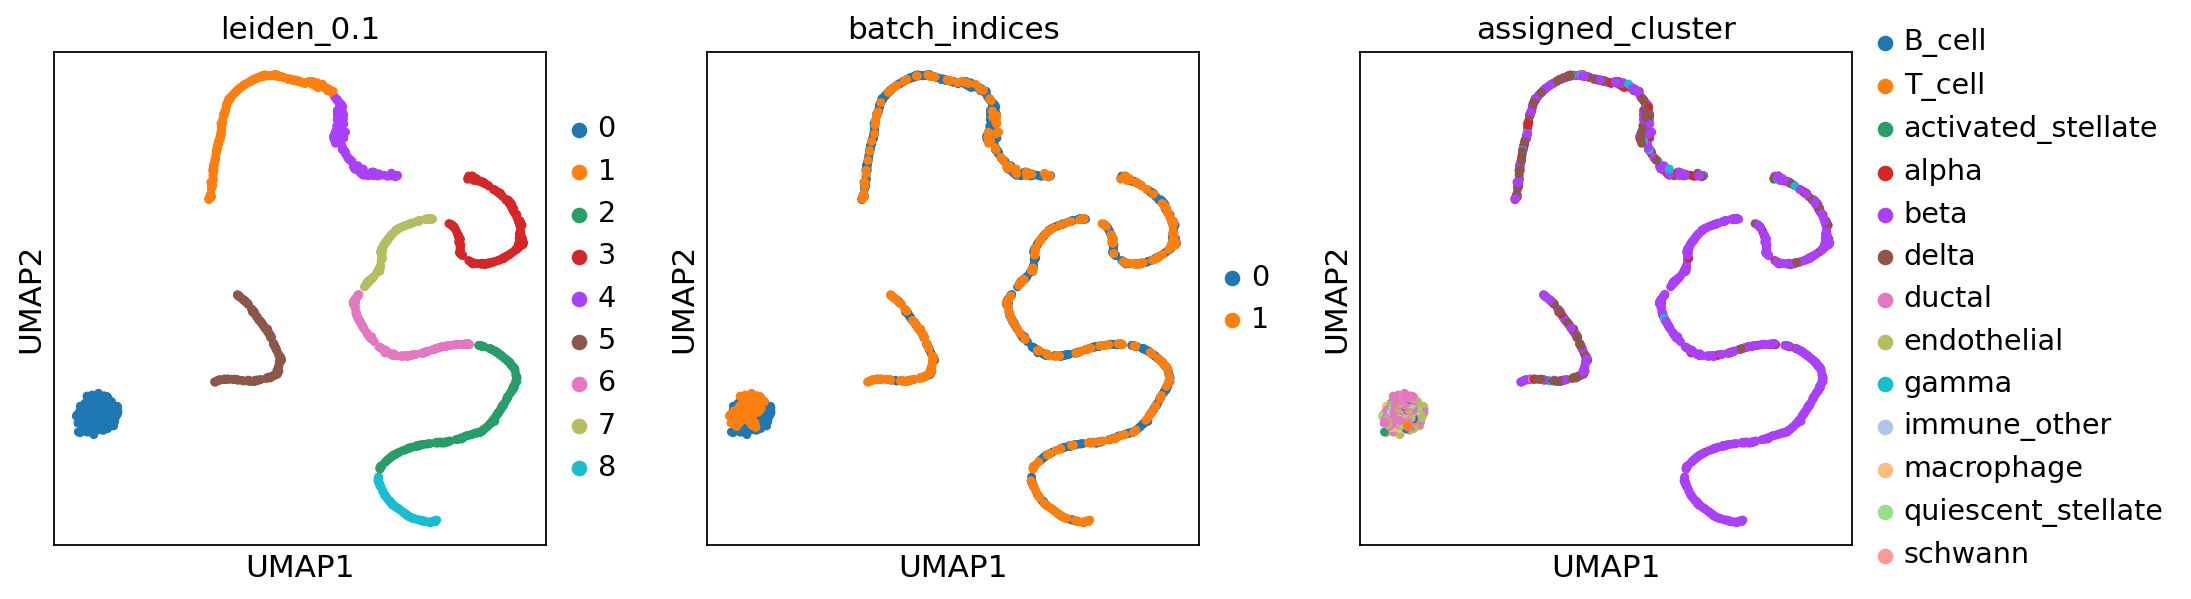

In [13]:
result = evaluate(adata_result, resolutions = [0.1, 0.13, 0.19, 0.22, 0.25, 0.28], return_fig=True, cell_type_col="assigned_cluster", batch_col="batch_indices")